# COVID-19 - analysis and prediction  


### Table of Contents:  
1. [Introduction](#Introduction)
2. [Checking the data](#Checking-the-data)
3. [Testing the data](#Testing-data)
4. [SVM](#SVM)
    - [Confirmed cases](#Confirmed-cases-SVM)
    - [Confirmed deaths](#Confirmed-deaths-SVM)
    - [Confirmed recoveries](#Confirmed-recoveries-SVM)
5. [Neural Network](#Neural-Network)
    - [Confirmed cases](#Confirmed-Cases-NN)
    - [Confirmed deaths](#Confirmed-deaths-NN)
    - [Confirmed recoveries](#Confirmed-recoveries-NN)
    - [Confirmed cases in Portugal](#Confirmed-Cases-Portugal-NN)
6. [Decision Tree](#Decision-Tree)
    - [Confirmed cases](#Confirmed-Cases-DT)
    - [Confirmed deaths](#Confirmed-deaths-DT)
    - [Confirmed recoveries](#Confirmed-recoveries-DT)
7. [Conclusion](#Conclusion)

**Authors: (Theme 4A)**    
Carlos Duarte - up201708804  
Simão Oliveira - up201603173  
Tiago Verdade - up201704003

# Introduction
For this project we have the objective of learning how to predict values using different algorithms and tools.  
To archieve this goal we will be predicting how covid-19 develops in terms of cases, deaths and recoveries in the world as well as cases in Portugal.  
During our work we used SVM, Neural Network and Decision Tree algorithms.

# Checking the data
First, it is required to analyse our dataset so that it is sure to not have any problems. To do so, we will print the first entries of the dataset:

In [4]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

data = pd.read_csv('data/covid19.csv', parse_dates=['Date'], infer_datetime_format=True)
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


The first problem we can identify is that some entries don't have a value on the *Country/Region* column.

We can fix this by assigning the value 'NA' to those entries:

In [5]:
# filling missing values 
data[['Province/State']] = data[['Province/State']].fillna('')
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,,Angola,-11.2027,17.8739,2020-01-22,0,0,0


There were some comments on Kaggle about repeated lines, it seems this is not the case.

In [6]:
duplicated_rows = data.duplicated()
duplicated_rows[duplicated_rows == True]

Series([], dtype: bool)

We can now take a look at some summary statistics about the data set:

In [7]:
data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2430.562420,147.948752,607.899531
std,24.740912,70.570899,23545.664313,1561.525918,5210.234488
min,-51.796300,-135.000000,-1.000000,-1.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,184.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


We see that the count is the same for values in the columns *Lat*, *Long*, *Confirmed*, *Deaths* and *Recovered*.

There is, however, something strange with this dataset: The minimum value for *Confirmed* and *Deaths* is -1. Because negative values don't make sense for these two columns, we will use **mean imputation** to replace them with the average number for each column.

In [8]:
average_confirmed_count = data['Confirmed'].mean()
data.loc[(data['Confirmed'] < 0), 'Confirmed'] = average_confirmed_count

average_death_count = data['Deaths'].mean()
data.loc[(data['Deaths'] < 0), 'Deaths'] = average_death_count

data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2432.399240,148.055347,607.899531
std,24.740912,70.570899,23545.569393,1561.520830,5210.234488
min,-51.796300,-135.000000,0.000000,0.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,185.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


Now  those columns make more sense.

Also, to ensure data integrity, we will replace any missing values with 0s.

In [9]:
data[['Confirmed', 'Deaths', 'Recovered']] = data[['Confirmed', 'Deaths', 'Recovered']].fillna(0)

### Testing data

In [10]:
assert len(data.loc[(data['Deaths'] < 0)]) == 0

assert len(data.loc[(data['Confirmed'] < 0)]) == 0

assert len(data.loc[(data['Recovered'] < 0)]) == 0

It would be a shame to lose all this tidied up data. Let's save it.

In [11]:
data.to_csv('data/covid19_clean.csv', index=False)

We'll now take a look at the scatterplot matrix now that we've tidied the data:

In [12]:
data_clean = pd.read_csv('data/covid19_clean.csv')
data_clean.fillna(data_clean.mean(), inplace=True)
# sb.pairplot(data.dropna())

---

# SVM

In [10]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

import numpy as np

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

number_days_predict = 15

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

train_days = np.array(epidemic_days[0:-number_days_predict]).reshape(-1, 1)
test_days = np.array(epidemic_days[-number_days_predict:]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

train_cases =  np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_cases = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

train_deaths = np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_deaths = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

train_recovered = np.array(world_recovered[0:-number_days_predict]).reshape(-1, 1)
test_recovered = np.array(world_recovered[-number_days_predict:]).reshape(-1, 1)

## Confirmed cases SVM

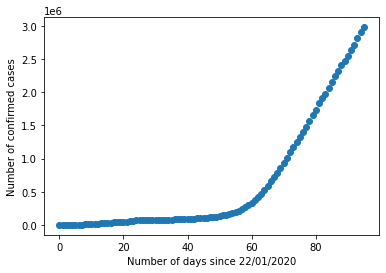

In [11]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

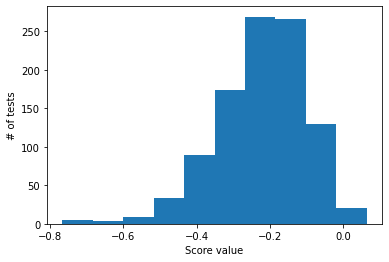

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

values = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_cases, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

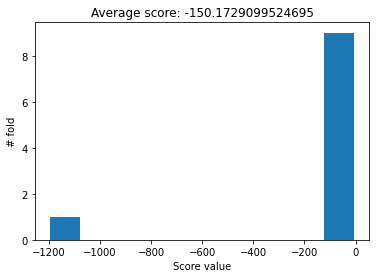

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_cases.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 6. After this we checked for the best combination for C and epsilon, and concluded that the lower the epsilon the better.  
With the epsilon fixed we then searched for the best combination of C and coef0.

*Beware this next block takes sometime to finish*

In [14]:
from sklearn.model_selection import GridSearchCV

svm = SVR(kernel='poly', degree=6, tol=1e-6, epsilon=0.001)

parameter_grid = {'C': np.arange(1, 40, 0.5),
                  'coef0': np.linspace(0.01, 1.0)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_cases.ravel())

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -57.929523665745215
Best parameters: {'C': 1.0, 'coef0': 0.13122448979591836}


In [15]:
svm_confirmed = grid_search.best_estimator_
print(svm_confirmed.get_params())

{'C': 1.0, 'cache_size': 200, 'coef0': 0.13122448979591836, 'degree': 6, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


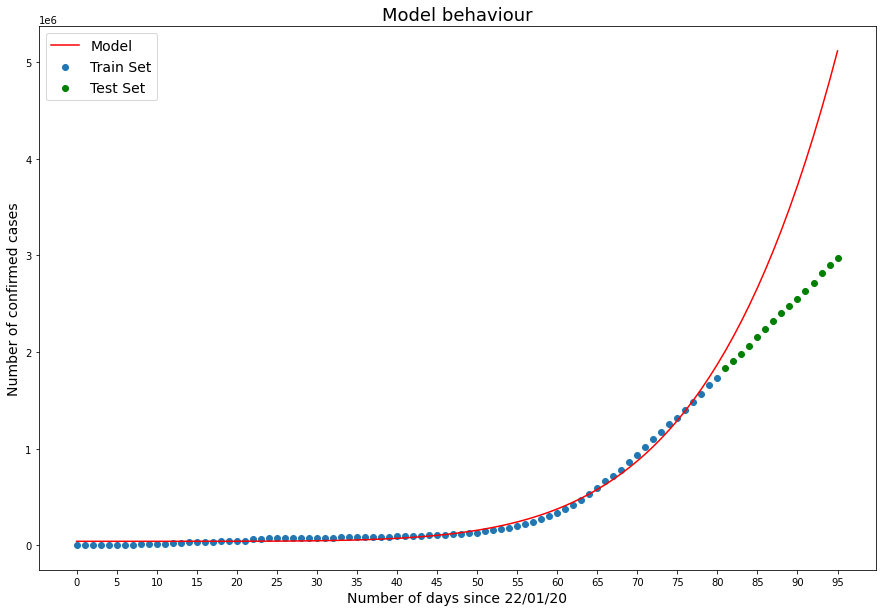

In [17]:
from sklearn.model_selection import cross_val_predict

pred = svm_confirmed.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_cases, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_cases.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_confirmed.png')
plt.show()

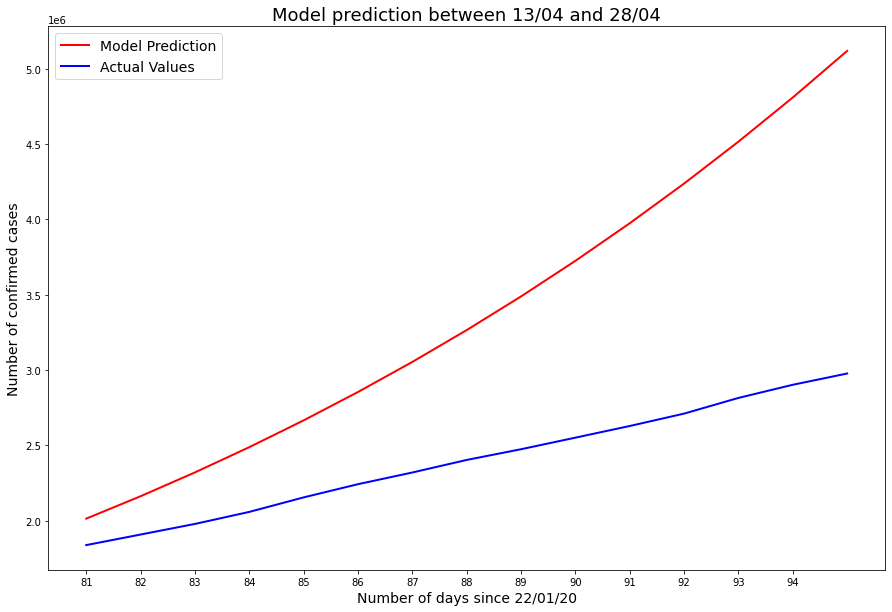

In [18]:
svr_pred_confirmed = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_confirmed, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_cases.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_confirmed_pred.png')
plt.show()

### Model statistics

In [19]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_cases, svr_pred_confirmed)
mae = mean_absolute_error(test_cases, svr_pred_confirmed)
mse = mean_squared_error(test_cases, svr_pred_confirmed)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		2142039.274
Mean Absolute Error: 	982382.836
Mean Squared Error: 	1332834514838.546


## Confirmed deaths SVM

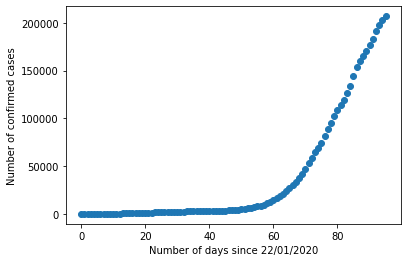

In [20]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

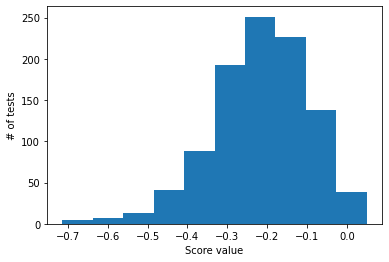

In [21]:
values = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_deaths, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

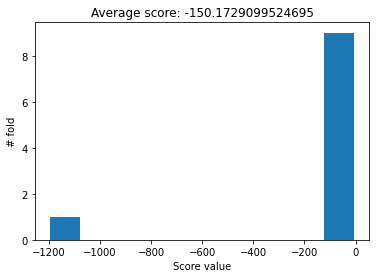

In [22]:
svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_deaths.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 5. After this we checked for the best combination for C and epsilon, contrary to what happened in the confirmed cases model here the lower epsilon didnt result in better results.  
With the epsilon fixed we then searched for the best combination of C and coef0.

*Beware this next block takes sometime to finish*

In [23]:
svm = SVR(kernel='poly', degree=5, tol=1e-6, epsilon=10)

parameter_grid = {'C': np.arange(1, 40, 0.5),
                  'coef0': np.linspace(0.01, 10)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_deaths.ravel())

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -27.63768414640136
Best parameters: {'C': 39.5, 'coef0': 3.679795918367347}


In [24]:
svm_deaths = grid_search.best_estimator_
print(svm_deaths.get_params())

{'C': 39.5, 'cache_size': 200, 'coef0': 3.679795918367347, 'degree': 5, 'epsilon': 10, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


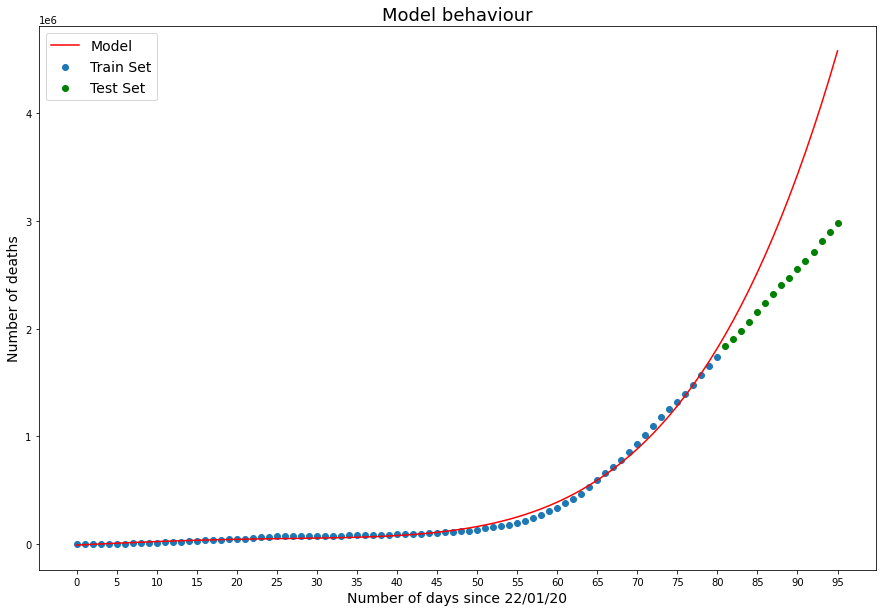

In [26]:
pred = svm_deaths.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_deaths, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_deaths.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_deaths_model.png')
plt.show()

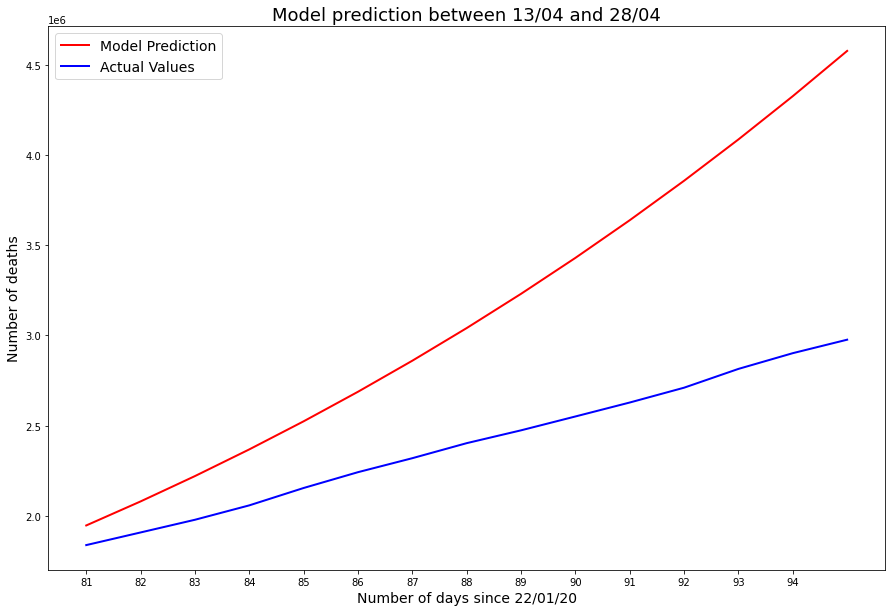

In [27]:
svr_pred_deaths = svm_deaths.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_deaths, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_deaths.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_deaths_pred.png')
plt.show()

### Model statistics

In [28]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_deaths, svr_pred_deaths)
mae = mean_absolute_error(test_deaths, svr_pred_deaths)
mse = mean_squared_error(test_deaths, svr_pred_deaths)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		1601655.943
Mean Absolute Error: 	728272.283
Mean Squared Error: 	742386552239.895


## Confirmed recoveries SVM

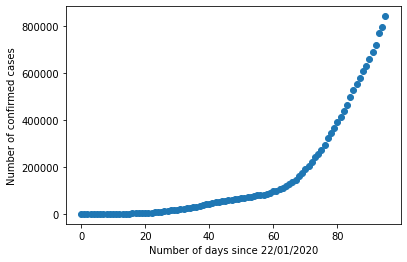

In [29]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

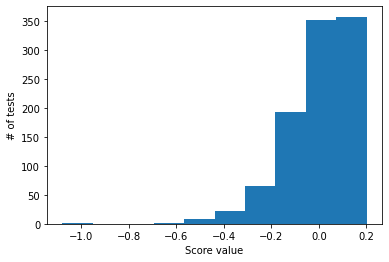

In [30]:
values = []

for repetition in range(1000):
    # Predict confirmed cases 
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_recovered, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

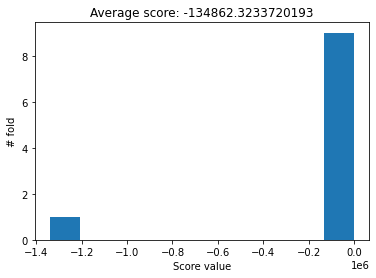

In [31]:
svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_recovered.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 4. After this we checked for the best combination for C and epsilon. After this first test we noticed that the regression was well behaved, meaning it followed better the number of recoveries. We also noticed that the best value for epsilon was higher than the ones previously used.  
Since this model was well behaved the tests were quicker.

In [32]:
svm = SVR(kernel='poly', degree=4, tol=1e-6, C=32.5, epsilon=454)

parameter_grid = {'coef0': np.linspace(1.0, 2.0)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_recovered.ravel())

print('Best score: {}'.format(abs(grid_search.best_score_)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 29.986501064486408
Best parameters: {'coef0': 1.8571428571428572}


In [33]:
svm_recoveries = grid_search.best_estimator_
print(svm_recoveries.get_params())

{'C': 32.5, 'cache_size': 200, 'coef0': 1.8571428571428572, 'degree': 4, 'epsilon': 454, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


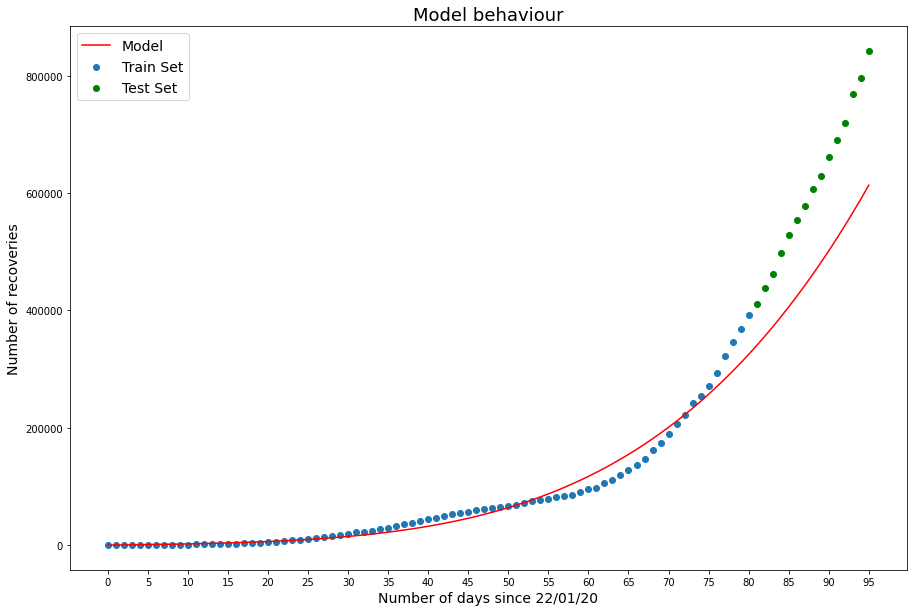

In [34]:
pred = svm_recoveries.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_recovered, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_recovered.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_recovered_model.png')
plt.show()

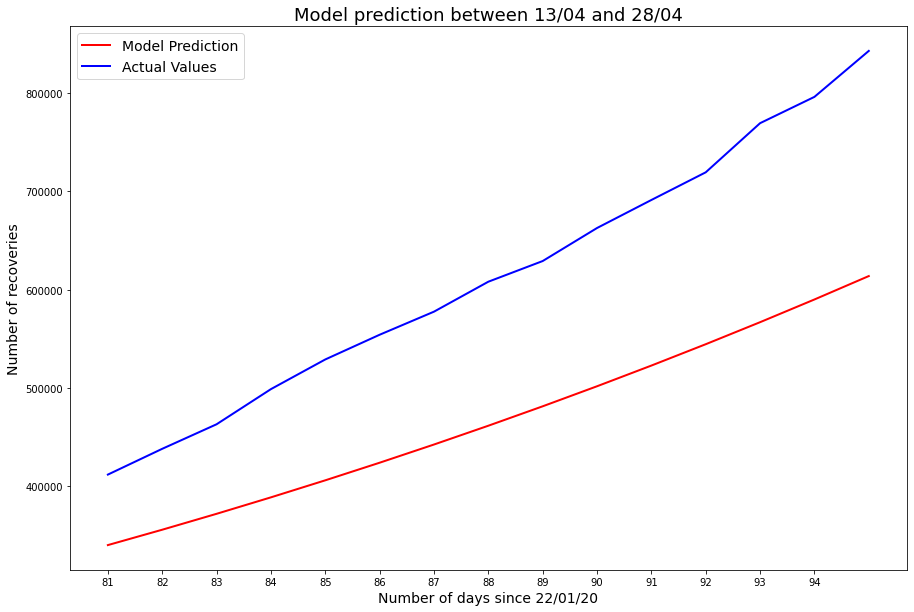

In [35]:
svr_pred_recoveries = svm_recoveries.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_recoveries, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_recovered.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_recovered_pred.png')
plt.show()

### Model statistics

In [36]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_recovered, svr_pred_recoveries)
mae = mean_absolute_error(test_recovered, svr_pred_recoveries)
mse = mean_squared_error(test_recovered, svr_pred_recoveries)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		229170.324
Mean Absolute Error: 	145387.601
Mean Squared Error: 	23142033248.139


# Neural Network

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [22]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []
portugal_cases = []

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']
    confirmed_portugal = data_clean.loc[(data_clean['Date'] == date) & (data_clean['Country/Region'] == 'Portugal'), 'Confirmed']
    
# data_clean['Country/Region'] == 'Portugal'
    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    total_confirmed_portugal = confirmed_portugal.sum();
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)
    portugal_cases.append(total_confirmed_portugal)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

# Number of confirmed cases in Portugal
portugal_cases = np.array(portugal_cases).reshape(-1, 1)

## Confirmed Cases NN

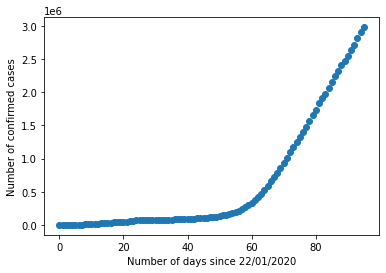

In [122]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [123]:
dp_world_cases = world_cases.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [124]:
# split into train and test sets
train_size = int(len(dp_world_cases) * 0.67)
test_size = len(dp_world_cases) - train_size
train, test = dp_world_cases[0:train_size], dp_world_cases[train_size:len(dp_world_cases)]
print(len(train), len(test))

64 32


We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [125]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [126]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_cases, look_back)
print(len(trainX), len(testX), len(finalX))

48 16 81


We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [133]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 77707114389.3333
Epoch 2/1000
 - 0s - loss: 51977456469.3333
Epoch 3/1000
 - 0s - loss: 32275047552.0000
Epoch 4/1000
 - 0s - loss: 20173623648.0000
Epoch 5/1000
 - 0s - loss: 12479966597.3333
Epoch 6/1000
 - 0s - loss: 6432993621.3333
Epoch 7/1000
 - 0s - loss: 2027815591.0000
Epoch 8/1000
 - 0s - loss: 565610899.9583
Epoch 9/1000
 - 0s - loss: 381640155.7005
Epoch 10/1000
 - 0s - loss: 367154157.0417
Epoch 11/1000
 - 0s - loss: 359609022.1250
Epoch 12/1000
 - 0s - loss: 351222937.6667
Epoch 13/1000
 - 0s - loss: 342126398.2500
Epoch 14/1000
 - 0s - loss: 338887308.0417
Epoch 15/1000
 - 0s - loss: 336521247.4688
Epoch 16/1000
 - 0s - loss: 327477224.6667
Epoch 17/1000
 - 0s - loss: 313285158.3333
Epoch 18/1000
 - 0s - loss: 302554623.5833
Epoch 19/1000
 - 0s - loss: 296658186.8333
Epoch 20/1000
 - 0s - loss: 286392190.9948
Epoch 21/1000
 - 0s - loss: 285061900.8333
Epoch 22/1000
 - 0s - loss: 271787447.1042
Epoch 23/1000
 - 0s - loss: 268827806.1667
Epoch 24

 - 0s - loss: 24123614.9486
Epoch 193/1000
 - 0s - loss: 23773845.9062
Epoch 194/1000
 - 0s - loss: 25295012.2760
Epoch 195/1000
 - 0s - loss: 25554479.4193
Epoch 196/1000
 - 0s - loss: 27095095.8490
Epoch 197/1000
 - 0s - loss: 27556136.5417
Epoch 198/1000
 - 0s - loss: 23263692.7161
Epoch 199/1000
 - 0s - loss: 21826635.7014
Epoch 200/1000
 - 0s - loss: 21965201.5872
Epoch 201/1000
 - 0s - loss: 21983392.9310
Epoch 202/1000
 - 0s - loss: 25878259.2448
Epoch 203/1000
 - 0s - loss: 22636397.8457
Epoch 204/1000
 - 0s - loss: 27517513.9396
Epoch 205/1000
 - 0s - loss: 23081041.2907
Epoch 206/1000
 - 0s - loss: 20294962.4772
Epoch 207/1000
 - 0s - loss: 21036214.6325
Epoch 208/1000
 - 0s - loss: 21994163.9753
Epoch 209/1000
 - 0s - loss: 28992256.6562
Epoch 210/1000
 - 0s - loss: 30954398.9062
Epoch 211/1000
 - 0s - loss: 22801278.9258
Epoch 212/1000
 - 0s - loss: 23152253.2793
Epoch 213/1000
 - 0s - loss: 24723568.9323
Epoch 214/1000
 - 0s - loss: 19984357.8867
Epoch 215/1000
 - 0s - los

Epoch 383/1000
 - 0s - loss: 15066427.6771
Epoch 384/1000
 - 0s - loss: 13443024.4792
Epoch 385/1000
 - 0s - loss: 16125761.1992
Epoch 386/1000
 - 0s - loss: 16494580.9115
Epoch 387/1000
 - 0s - loss: 14009577.5260
Epoch 388/1000
 - 0s - loss: 18769472.5352
Epoch 389/1000
 - 0s - loss: 11966700.3802
Epoch 390/1000
 - 0s - loss: 12686840.1237
Epoch 391/1000
 - 0s - loss: 14091246.3073
Epoch 392/1000
 - 0s - loss: 17339310.0521
Epoch 393/1000
 - 0s - loss: 12567619.1458
Epoch 394/1000
 - 0s - loss: 12254185.2760
Epoch 395/1000
 - 0s - loss: 14188425.5710
Epoch 396/1000
 - 0s - loss: 11574278.0234
Epoch 397/1000
 - 0s - loss: 10659629.0312
Epoch 398/1000
 - 0s - loss: 11474541.2370
Epoch 399/1000
 - 0s - loss: 11829299.0833
Epoch 400/1000
 - 0s - loss: 12345622.3984
Epoch 401/1000
 - 0s - loss: 13221593.6862
Epoch 402/1000
 - 0s - loss: 13018752.2461
Epoch 403/1000
 - 0s - loss: 12168183.4773
Epoch 404/1000
 - 0s - loss: 12432238.0039
Epoch 405/1000
 - 0s - loss: 11127991.7708
Epoch 406/1

Epoch 574/1000
 - 0s - loss: 10562942.0833
Epoch 575/1000
 - 0s - loss: 11419628.1309
Epoch 576/1000
 - 0s - loss: 12079876.3776
Epoch 577/1000
 - 0s - loss: 11110704.3815
Epoch 578/1000
 - 0s - loss: 11830314.3438
Epoch 579/1000
 - 0s - loss: 11326857.7891
Epoch 580/1000
 - 0s - loss: 14139504.0846
Epoch 581/1000
 - 0s - loss: 10916874.7832
Epoch 582/1000
 - 0s - loss: 14816124.9323
Epoch 583/1000
 - 0s - loss: 18119670.2943
Epoch 584/1000
 - 0s - loss: 14484689.8906
Epoch 585/1000
 - 0s - loss: 12087756.2396
Epoch 586/1000
 - 0s - loss: 11122691.1615
Epoch 587/1000
 - 0s - loss: 10872619.5443
Epoch 588/1000
 - 0s - loss: 12768178.4479
Epoch 589/1000
 - 0s - loss: 13535475.1549
Epoch 590/1000
 - 0s - loss: 12271869.4619
Epoch 591/1000
 - 0s - loss: 10040528.1243
Epoch 592/1000
 - 0s - loss: 12884751.4648
Epoch 593/1000
 - 0s - loss: 13524818.1413
Epoch 594/1000
 - 0s - loss: 10384059.2292
Epoch 595/1000
 - 0s - loss: 11334530.2591
Epoch 596/1000
 - 0s - loss: 10478466.2708
Epoch 597/1

Epoch 765/1000
 - 0s - loss: 17268997.9701
Epoch 766/1000
 - 0s - loss: 17283264.0182
Epoch 767/1000
 - 0s - loss: 17089333.6680
Epoch 768/1000
 - 0s - loss: 10534603.5729
Epoch 769/1000
 - 0s - loss: 9605469.0065
Epoch 770/1000
 - 0s - loss: 14130667.7324
Epoch 771/1000
 - 0s - loss: 10255018.7148
Epoch 772/1000
 - 0s - loss: 11904227.7053
Epoch 773/1000
 - 0s - loss: 16798382.7448
Epoch 774/1000
 - 0s - loss: 14670124.8477
Epoch 775/1000
 - 0s - loss: 12429894.6719
Epoch 776/1000
 - 0s - loss: 9935447.6624
Epoch 777/1000
 - 0s - loss: 10780384.6354
Epoch 778/1000
 - 0s - loss: 11052167.5853
Epoch 779/1000
 - 0s - loss: 12157986.0400
Epoch 780/1000
 - 0s - loss: 11500728.6673
Epoch 781/1000
 - 0s - loss: 20219669.1061
Epoch 782/1000
 - 0s - loss: 41042504.4271
Epoch 783/1000
 - 0s - loss: 27284905.7448
Epoch 784/1000
 - 0s - loss: 11869278.6390
Epoch 785/1000
 - 0s - loss: 12720645.2943
Epoch 786/1000
 - 0s - loss: 12988081.4544
Epoch 787/1000
 - 0s - loss: 19396963.6764
Epoch 788/100

Epoch 956/1000
 - 0s - loss: 15339995.7575
Epoch 957/1000
 - 0s - loss: 10036284.7520
Epoch 958/1000
 - 0s - loss: 9976967.4714
Epoch 959/1000
 - 0s - loss: 10534682.5757
Epoch 960/1000
 - 0s - loss: 10747258.4297
Epoch 961/1000
 - 0s - loss: 14492327.7695
Epoch 962/1000
 - 0s - loss: 25929928.9870
Epoch 963/1000
 - 0s - loss: 11328040.5889
Epoch 964/1000
 - 0s - loss: 11463071.0247
Epoch 965/1000
 - 0s - loss: 16107178.9792
Epoch 966/1000
 - 0s - loss: 10009803.4427
Epoch 967/1000
 - 0s - loss: 12065196.0599
Epoch 968/1000
 - 0s - loss: 11215502.4609
Epoch 969/1000
 - 0s - loss: 13018864.6637
Epoch 970/1000
 - 0s - loss: 14133704.3971
Epoch 971/1000
 - 0s - loss: 11221775.8379
Epoch 972/1000
 - 0s - loss: 12047043.9124
Epoch 973/1000
 - 0s - loss: 10684618.4349
Epoch 974/1000
 - 0s - loss: 12457349.6419
Epoch 975/1000
 - 0s - loss: 30569767.2051
Epoch 976/1000
 - 0s - loss: 12272235.4854
Epoch 977/1000
 - 0s - loss: 14775618.5534
Epoch 978/1000
 - 0s - loss: 13608514.1418
Epoch 979/10

Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [135]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 11748829.33 MSE (3427.66 RMSE)
Test Score: 300482080.00 MSE (17334.42 RMSE)


Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

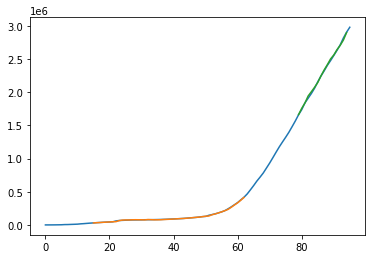

In [136]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_cases)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_cases)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_cases)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [137]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_cases[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [138]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

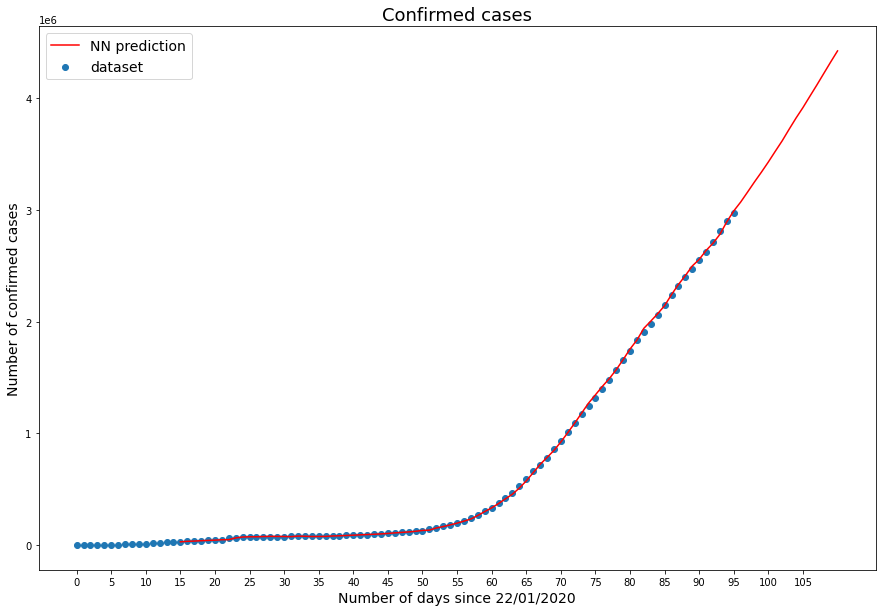

In [140]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_cases, label='dataset')
plt.title('Confirmed cases', fontsize=18)
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days+look_back), 5.0))
plt.xlabel('Number of days since 22/01/2020',fontsize=14)
plt.ylabel('Number of confirmed cases',fontsize=14)
plt.plot(allTest, label='NN prediction', color='red')
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/NN_confirmed.png')
plt.show()

And here we can see the graph with all previsions made.

## Confirmed deaths NN

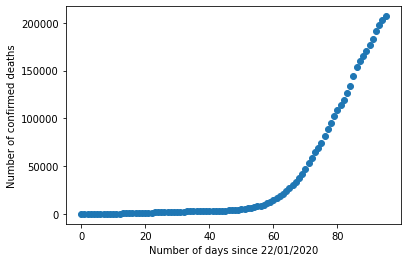

In [196]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed deaths')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [197]:
dp_world_deaths = world_deaths.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [198]:
# split into train and test sets
train_size = int(len(dp_world_deaths) * 0.67)
test_size = len(dp_world_deaths) - train_size
train, test = dp_world_deaths[0:train_size], dp_world_deaths[train_size:len(dp_world_deaths)]
print(len(train), len(test))

64 32


We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [199]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [200]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_deaths, look_back)
print(len(trainX), len(testX), len(finalX))

48 16 81


We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [207]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(15, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 30663001.0781
Epoch 2/1000
 - 0s - loss: 17106512.5339
Epoch 3/1000
 - 0s - loss: 10402089.4329
Epoch 4/1000
 - 0s - loss: 2325063.2529
Epoch 5/1000
 - 0s - loss: 1062923.2518
Epoch 6/1000
 - 0s - loss: 675233.8265
Epoch 7/1000
 - 0s - loss: 541942.3477
Epoch 8/1000
 - 0s - loss: 475242.3968
Epoch 9/1000
 - 0s - loss: 418084.0988
Epoch 10/1000
 - 0s - loss: 327545.5125
Epoch 11/1000
 - 0s - loss: 261144.3067
Epoch 12/1000
 - 0s - loss: 244248.4117
Epoch 13/1000
 - 0s - loss: 232961.1037
Epoch 14/1000
 - 0s - loss: 169653.8890
Epoch 15/1000
 - 0s - loss: 152769.1208
Epoch 16/1000
 - 0s - loss: 114656.8018
Epoch 17/1000
 - 0s - loss: 99048.1040
Epoch 18/1000
 - 0s - loss: 71627.2770
Epoch 19/1000
 - 0s - loss: 59813.7196
Epoch 20/1000
 - 0s - loss: 55820.1726
Epoch 21/1000
 - 0s - loss: 47512.6052
Epoch 22/1000
 - 0s - loss: 35571.4461
Epoch 23/1000
 - 0s - loss: 33074.0094
Epoch 24/1000
 - 0s - loss: 28649.7199
Epoch 25/1000
 - 0s - loss: 25655.4708
Epoch 26/1

 - 0s - loss: 9311.8043
Epoch 209/1000
 - 0s - loss: 16838.9052
Epoch 210/1000
 - 0s - loss: 9801.0386
Epoch 211/1000
 - 0s - loss: 9045.6855
Epoch 212/1000
 - 0s - loss: 12368.7588
Epoch 213/1000
 - 0s - loss: 23968.7221
Epoch 214/1000
 - 0s - loss: 11260.4605
Epoch 215/1000
 - 0s - loss: 12972.8009
Epoch 216/1000
 - 0s - loss: 31939.2159
Epoch 217/1000
 - 0s - loss: 41185.1757
Epoch 218/1000
 - 0s - loss: 39504.9753
Epoch 219/1000
 - 0s - loss: 31424.8530
Epoch 220/1000
 - 0s - loss: 12468.0863
Epoch 221/1000
 - 0s - loss: 10438.5074
Epoch 222/1000
 - 0s - loss: 10894.8931
Epoch 223/1000
 - 0s - loss: 9274.4622
Epoch 224/1000
 - 0s - loss: 8706.5046
Epoch 225/1000
 - 0s - loss: 11960.6058
Epoch 226/1000
 - 0s - loss: 9945.0511
Epoch 227/1000
 - 0s - loss: 14579.1050
Epoch 228/1000
 - 0s - loss: 13424.5343
Epoch 229/1000
 - 0s - loss: 9434.1708
Epoch 230/1000
 - 0s - loss: 19839.3624
Epoch 231/1000
 - 0s - loss: 10372.3176
Epoch 232/1000
 - 0s - loss: 14723.0974
Epoch 233/1000
 - 0s -

 - 0s - loss: 14894.7063
Epoch 415/1000
 - 0s - loss: 10395.0055
Epoch 416/1000
 - 0s - loss: 10182.9815
Epoch 417/1000
 - 0s - loss: 15988.6930
Epoch 418/1000
 - 0s - loss: 13498.0178
Epoch 419/1000
 - 0s - loss: 9652.6604
Epoch 420/1000
 - 0s - loss: 13761.7155
Epoch 421/1000
 - 0s - loss: 13493.6104
Epoch 422/1000
 - 0s - loss: 17145.8905
Epoch 423/1000
 - 0s - loss: 27705.7044
Epoch 424/1000
 - 0s - loss: 39053.9289
Epoch 425/1000
 - 0s - loss: 12883.5387
Epoch 426/1000
 - 0s - loss: 13044.3071
Epoch 427/1000
 - 0s - loss: 8475.2305
Epoch 428/1000
 - 0s - loss: 36370.6205
Epoch 429/1000
 - 0s - loss: 42163.5357
Epoch 430/1000
 - 0s - loss: 29861.3745
Epoch 431/1000
 - 0s - loss: 11326.4128
Epoch 432/1000
 - 0s - loss: 8637.9519
Epoch 433/1000
 - 0s - loss: 8270.1176
Epoch 434/1000
 - 0s - loss: 11700.2770
Epoch 435/1000
 - 0s - loss: 19137.7491
Epoch 436/1000
 - 0s - loss: 15995.2172
Epoch 437/1000
 - 0s - loss: 18497.3812
Epoch 438/1000
 - 0s - loss: 10064.8243
Epoch 439/1000
 - 0

Epoch 621/1000
 - 0s - loss: 17986.3450
Epoch 622/1000
 - 0s - loss: 19714.1716
Epoch 623/1000
 - 0s - loss: 13540.5124
Epoch 624/1000
 - 0s - loss: 14146.0961
Epoch 625/1000
 - 0s - loss: 12723.5254
Epoch 626/1000
 - 0s - loss: 15362.4367
Epoch 627/1000
 - 0s - loss: 19784.9107
Epoch 628/1000
 - 0s - loss: 13153.6762
Epoch 629/1000
 - 0s - loss: 16313.4489
Epoch 630/1000
 - 0s - loss: 19108.2199
Epoch 631/1000
 - 0s - loss: 22385.8906
Epoch 632/1000
 - 0s - loss: 12951.6727
Epoch 633/1000
 - 0s - loss: 10263.6641
Epoch 634/1000
 - 0s - loss: 17060.3272
Epoch 635/1000
 - 0s - loss: 127343.5214
Epoch 636/1000
 - 0s - loss: 34130.3850
Epoch 637/1000
 - 0s - loss: 29612.8090
Epoch 638/1000
 - 0s - loss: 12512.8150
Epoch 639/1000
 - 0s - loss: 16156.1973
Epoch 640/1000
 - 0s - loss: 8420.7049
Epoch 641/1000
 - 0s - loss: 9002.7777
Epoch 642/1000
 - 0s - loss: 10988.6266
Epoch 643/1000
 - 0s - loss: 14056.5564
Epoch 644/1000
 - 0s - loss: 9508.2401
Epoch 645/1000
 - 0s - loss: 8699.3889
Epo

Epoch 828/1000
 - 0s - loss: 10437.7924
Epoch 829/1000
 - 0s - loss: 12804.4574
Epoch 830/1000
 - 0s - loss: 15095.1248
Epoch 831/1000
 - 0s - loss: 10496.6280
Epoch 832/1000
 - 0s - loss: 16016.7531
Epoch 833/1000
 - 0s - loss: 10303.7514
Epoch 834/1000
 - 0s - loss: 9366.4520
Epoch 835/1000
 - 0s - loss: 8324.7484
Epoch 836/1000
 - 0s - loss: 8440.7397
Epoch 837/1000
 - 0s - loss: 15494.1077
Epoch 838/1000
 - 0s - loss: 15884.3877
Epoch 839/1000
 - 0s - loss: 20388.1837
Epoch 840/1000
 - 0s - loss: 55104.7576
Epoch 841/1000
 - 0s - loss: 74544.6553
Epoch 842/1000
 - 0s - loss: 60587.3065
Epoch 843/1000
 - 0s - loss: 9525.6323
Epoch 844/1000
 - 0s - loss: 10644.9363
Epoch 845/1000
 - 0s - loss: 9760.5662
Epoch 846/1000
 - 0s - loss: 8079.9111
Epoch 847/1000
 - 0s - loss: 6994.4049
Epoch 848/1000
 - 0s - loss: 16299.3149
Epoch 849/1000
 - 0s - loss: 14440.8980
Epoch 850/1000
 - 0s - loss: 10251.0062
Epoch 851/1000
 - 0s - loss: 11244.6403
Epoch 852/1000
 - 0s - loss: 14521.3401
Epoch 8

Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [208]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 21869.12 MSE (147.88 RMSE)
Test Score: 11920774.00 MSE (3452.65 RMSE)


Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

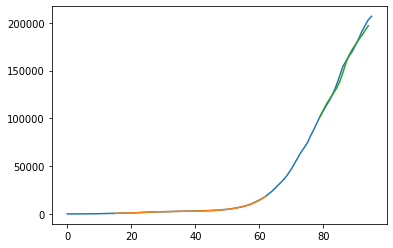

In [209]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_deaths)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_deaths)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_deaths)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_deaths)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [210]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_deaths[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [211]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

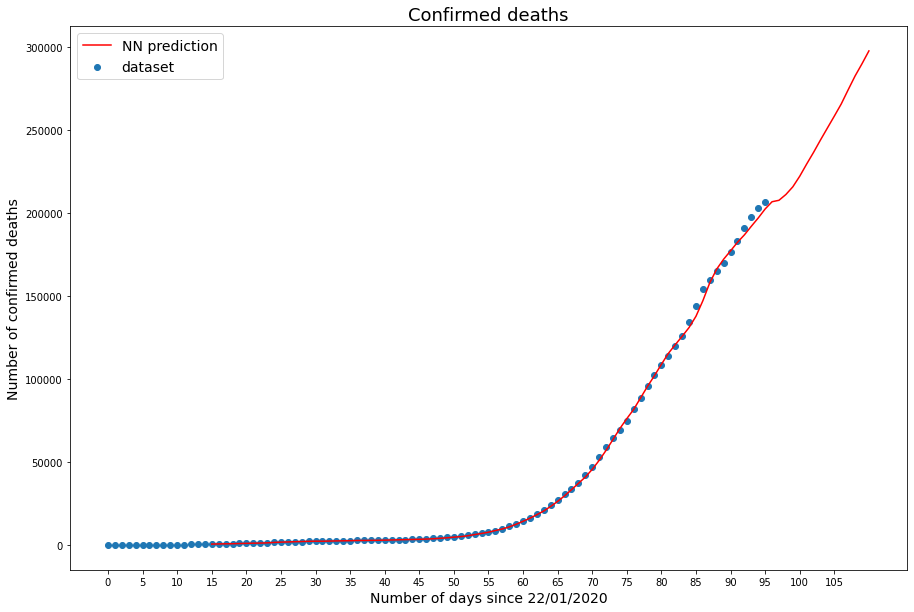

In [212]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_deaths, label='dataset')
plt.title('Confirmed deaths', fontsize=18)
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days+look_back), 5.0))
plt.xlabel('Number of days since 22/01/2020',fontsize=14)
plt.ylabel('Number of confirmed deaths',fontsize=14)
plt.plot(allTest, label='NN prediction', color='red')
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/NN_deaths.png')
plt.show()

And here we can see the graph with all previsions made.

## Confirmed recoveries NN

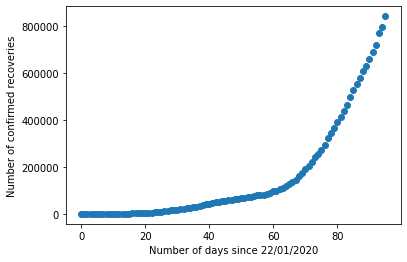

In [177]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed recoveries')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [178]:
dp_world_recoveries = world_recovered.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [179]:
# split into train and test sets
train_size = int(len(dp_world_recoveries) * 0.67)
test_size = len(dp_world_recoveries) - train_size
train, test = dp_world_recoveries[0:train_size], dp_world_recoveries[train_size:len(dp_world_deaths)]
print(len(train), len(test))

64 32


We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [180]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [181]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_recoveries, look_back)
print(len(trainX), len(testX), len(finalX))

48 16 81


We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [182]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 626002460.0000
Epoch 2/1000
 - 0s - loss: 302232507.1667
Epoch 3/1000
 - 0s - loss: 122182261.0208
Epoch 4/1000
 - 0s - loss: 43129129.5833
Epoch 5/1000
 - 0s - loss: 38441449.2708
Epoch 6/1000
 - 0s - loss: 34576635.3229
Epoch 7/1000
 - 0s - loss: 33526751.7292
Epoch 8/1000
 - 0s - loss: 30812817.1068
Epoch 9/1000
 - 0s - loss: 25710643.8229
Epoch 10/1000
 - 0s - loss: 24186181.6146
Epoch 11/1000
 - 0s - loss: 21648186.3698
Epoch 12/1000
 - 0s - loss: 19366307.9531
Epoch 13/1000
 - 0s - loss: 17701432.6875
Epoch 14/1000
 - 0s - loss: 16713034.6354
Epoch 15/1000
 - 0s - loss: 15151813.0990
Epoch 16/1000
 - 0s - loss: 13155371.5052
Epoch 17/1000
 - 0s - loss: 12015545.1875
Epoch 18/1000
 - 0s - loss: 10539373.5339
Epoch 19/1000
 - 0s - loss: 8930262.0469
Epoch 20/1000
 - 0s - loss: 7942450.2370
Epoch 21/1000
 - 0s - loss: 7174979.1927
Epoch 22/1000
 - 0s - loss: 6373290.9974
Epoch 23/1000
 - 0s - loss: 5876217.5666
Epoch 24/1000
 - 0s - loss: 5227792.1802
Epoc

 - 0s - loss: 2085505.1833
Epoch 199/1000
 - 0s - loss: 1843925.6508
Epoch 200/1000
 - 0s - loss: 2124579.4212
Epoch 201/1000
 - 0s - loss: 3243760.1172
Epoch 202/1000
 - 0s - loss: 2355376.5252
Epoch 203/1000
 - 0s - loss: 1989472.3718
Epoch 204/1000
 - 0s - loss: 1961652.4902
Epoch 205/1000
 - 0s - loss: 1981739.8190
Epoch 206/1000
 - 0s - loss: 2796768.1901
Epoch 207/1000
 - 0s - loss: 2550841.2786
Epoch 208/1000
 - 0s - loss: 1946639.1066
Epoch 209/1000
 - 0s - loss: 2158462.0547
Epoch 210/1000
 - 0s - loss: 2086969.6512
Epoch 211/1000
 - 0s - loss: 2012912.4541
Epoch 212/1000
 - 0s - loss: 2585630.0379
Epoch 213/1000
 - 0s - loss: 2450610.4577
Epoch 214/1000
 - 0s - loss: 2295173.5710
Epoch 215/1000
 - 0s - loss: 1809313.7672
Epoch 216/1000
 - 0s - loss: 1997531.2168
Epoch 217/1000
 - 0s - loss: 2111027.9870
Epoch 218/1000
 - 0s - loss: 3151998.2106
Epoch 219/1000
 - 0s - loss: 1993393.7389
Epoch 220/1000
 - 0s - loss: 1920111.0416
Epoch 221/1000
 - 0s - loss: 2129138.1174
Epoch 2

Epoch 394/1000
 - 0s - loss: 1843917.8848
Epoch 395/1000
 - 0s - loss: 1907789.3524
Epoch 396/1000
 - 0s - loss: 1774093.2445
Epoch 397/1000
 - 0s - loss: 1895079.9974
Epoch 398/1000
 - 0s - loss: 2106214.2956
Epoch 399/1000
 - 0s - loss: 2059480.8138
Epoch 400/1000
 - 0s - loss: 2014388.2455
Epoch 401/1000
 - 0s - loss: 1856680.0306
Epoch 402/1000
 - 0s - loss: 1896937.6595
Epoch 403/1000
 - 0s - loss: 1895030.3506
Epoch 404/1000
 - 0s - loss: 2231622.2518
Epoch 405/1000
 - 0s - loss: 2005156.3519
Epoch 406/1000
 - 0s - loss: 2177630.8324
Epoch 407/1000
 - 0s - loss: 1956739.7364
Epoch 408/1000
 - 0s - loss: 2021188.8053
Epoch 409/1000
 - 0s - loss: 2070715.8600
Epoch 410/1000
 - 0s - loss: 2020042.5361
Epoch 411/1000
 - 0s - loss: 1965820.8158
Epoch 412/1000
 - 0s - loss: 2161981.2912
Epoch 413/1000
 - 0s - loss: 1856254.1211
Epoch 414/1000
 - 0s - loss: 1824156.9281
Epoch 415/1000
 - 0s - loss: 2404954.5384
Epoch 416/1000
 - 0s - loss: 3017075.1270
Epoch 417/1000
 - 0s - loss: 25741

 - 0s - loss: 2412623.5094
Epoch 590/1000
 - 0s - loss: 2557961.2666
Epoch 591/1000
 - 0s - loss: 2918626.2321
Epoch 592/1000
 - 0s - loss: 3612678.0238
Epoch 593/1000
 - 0s - loss: 2064690.8966
Epoch 594/1000
 - 0s - loss: 2455274.7712
Epoch 595/1000
 - 0s - loss: 1640982.0656
Epoch 596/1000
 - 0s - loss: 1738030.3926
Epoch 597/1000
 - 0s - loss: 2115210.9793
Epoch 598/1000
 - 0s - loss: 1988393.2695
Epoch 599/1000
 - 0s - loss: 2318326.6803
Epoch 600/1000
 - 0s - loss: 1839660.1007
Epoch 601/1000
 - 0s - loss: 1780342.0400
Epoch 602/1000
 - 0s - loss: 1786353.2233
Epoch 603/1000
 - 0s - loss: 1986678.3947
Epoch 604/1000
 - 0s - loss: 1695111.3997
Epoch 605/1000
 - 0s - loss: 1671143.3753
Epoch 606/1000
 - 0s - loss: 1912478.1416
Epoch 607/1000
 - 0s - loss: 1525322.8405
Epoch 608/1000
 - 0s - loss: 1931528.0931
Epoch 609/1000
 - 0s - loss: 2367835.6156
Epoch 610/1000
 - 0s - loss: 2762631.3004
Epoch 611/1000
 - 0s - loss: 3847741.3691
Epoch 612/1000
 - 0s - loss: 3103378.1748
Epoch 6

Epoch 785/1000
 - 0s - loss: 2045073.7059
Epoch 786/1000
 - 0s - loss: 1998968.6201
Epoch 787/1000
 - 0s - loss: 1713889.9979
Epoch 788/1000
 - 0s - loss: 1764525.3052
Epoch 789/1000
 - 0s - loss: 1537781.7428
Epoch 790/1000
 - 0s - loss: 1749151.3874
Epoch 791/1000
 - 0s - loss: 3630162.1424
Epoch 792/1000
 - 0s - loss: 2510158.5385
Epoch 793/1000
 - 0s - loss: 2087296.9606
Epoch 794/1000
 - 0s - loss: 1745138.5293
Epoch 795/1000
 - 0s - loss: 1595606.7826
Epoch 796/1000
 - 0s - loss: 1769086.0047
Epoch 797/1000
 - 0s - loss: 1756185.9995
Epoch 798/1000
 - 0s - loss: 1878545.2363
Epoch 799/1000
 - 0s - loss: 2140022.3133
Epoch 800/1000
 - 0s - loss: 1872606.1415
Epoch 801/1000
 - 0s - loss: 1709110.1025
Epoch 802/1000
 - 0s - loss: 1750733.0684
Epoch 803/1000
 - 0s - loss: 2635555.6289
Epoch 804/1000
 - 0s - loss: 1859976.5065
Epoch 805/1000
 - 0s - loss: 2006635.1030
Epoch 806/1000
 - 0s - loss: 1803050.2897
Epoch 807/1000
 - 0s - loss: 1765375.4608
Epoch 808/1000
 - 0s - loss: 19712

Epoch 981/1000
 - 0s - loss: 1665828.9912
Epoch 982/1000
 - 0s - loss: 1440323.4697
Epoch 983/1000
 - 0s - loss: 1562073.7822
Epoch 984/1000
 - 0s - loss: 1628070.2685
Epoch 985/1000
 - 0s - loss: 1746692.6056
Epoch 986/1000
 - 0s - loss: 1939081.1680
Epoch 987/1000
 - 0s - loss: 2081917.4803
Epoch 988/1000
 - 0s - loss: 1997149.7087
Epoch 989/1000
 - 0s - loss: 1838841.6274
Epoch 990/1000
 - 0s - loss: 1582222.2389
Epoch 991/1000
 - 0s - loss: 1909427.2770
Epoch 992/1000
 - 0s - loss: 1686058.6341
Epoch 993/1000
 - 0s - loss: 1994982.9036
Epoch 994/1000
 - 0s - loss: 1590184.1040
Epoch 995/1000
 - 0s - loss: 1732187.7692
Epoch 996/1000
 - 0s - loss: 1518283.9098
Epoch 997/1000
 - 0s - loss: 1921916.1525
Epoch 998/1000
 - 0s - loss: 2180647.9087
Epoch 999/1000
 - 0s - loss: 1557370.9591
Epoch 1000/1000
 - 0s - loss: 1538742.3725


Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [183]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 1625956.42 MSE (1275.13 RMSE)
Test Score: 91572208.00 MSE (9569.34 RMSE)


Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

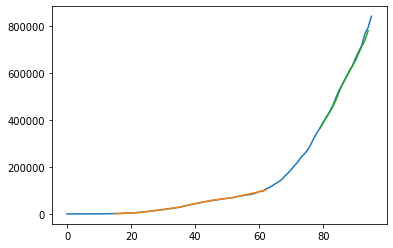

In [184]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_recoveries)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_recoveries)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_recoveries)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_recoveries)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [185]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_recoveries[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [186]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

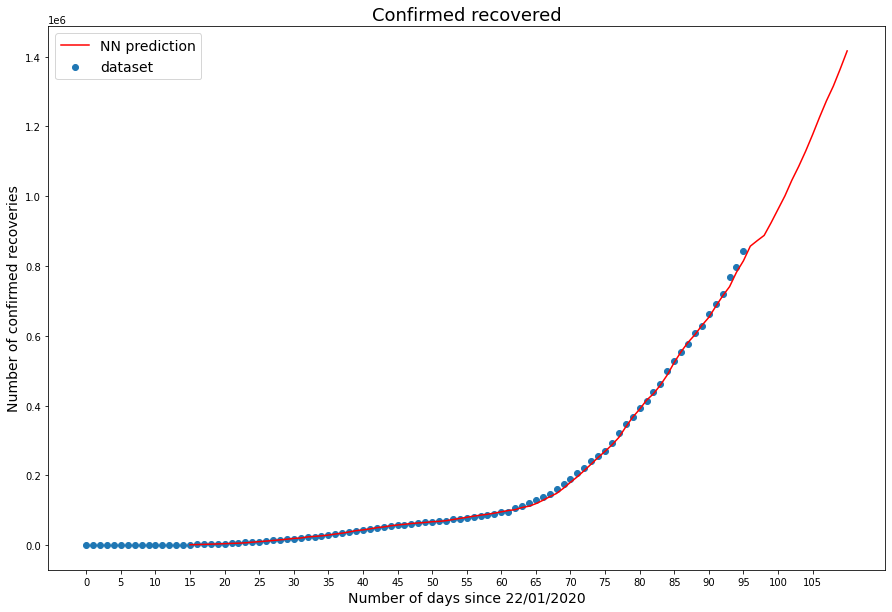

In [190]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_recoveries, label='dataset')
plt.title('Confirmed recovered', fontsize=18)
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days+look_back), 5.0))
plt.xlabel('Number of days since 22/01/2020',fontsize=14)
plt.ylabel('Number of confirmed recoveries',fontsize=14)
plt.plot(allTest, label='NN prediction', color='red')
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/NN_recovered.png')
plt.show()

And here we can see the graph with all previsions made.

## Confirmed Cases Portugal NN

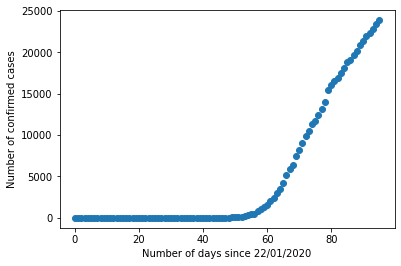

In [23]:
plt.scatter(x=epidemic_days, y=portugal_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [24]:
dp_portugal_cases = portugal_cases.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [92]:
# split into train and test sets
train_size = int(len(dp_portugal_cases) * 1)
test_size = len(dp_portugal_cases) - train_size
train, test = dp_portugal_cases[0:train_size], dp_portugal_cases[train_size:len(dp_portugal_cases)]
print(len(train), len(test))

96 0


We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [93]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [101]:
# reshape dataset
look_back = 15
days_predict_future = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_portugal_cases, look_back)
print(len(trainX), len(testX), len(finalX))

80 0 81


We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [95]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(15, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Epoch 1/1000
 - 0s - loss: 70372225.4581
Epoch 2/1000
 - 0s - loss: 22496655.9651
Epoch 3/1000
 - 0s - loss: 8230070.9928
Epoch 4/1000
 - 0s - loss: 5403263.4101
Epoch 5/1000
 - 0s - loss: 4502683.5322
Epoch 6/1000
 - 0s - loss: 3790678.2539
Epoch 7/1000
 - 0s - loss: 3422405.6373
Epoch 8/1000
 - 0s - loss: 3035691.8076
Epoch 9/1000
 - 0s - loss: 2496251.6908
Epoch 10/1000
 - 0s - loss: 2507539.8304
Epoch 11/1000
 - 0s - loss: 2438682.2825
Epoch 12/1000
 - 0s - loss: 1764314.4023
Epoch 13/1000
 - 0s - loss: 1481102.9485
Epoch 14/1000
 - 0s - loss: 1279277.7787
Epoch 15/1000
 - 0s - loss: 1011386.0610
Epoch 16/1000
 - 0s - loss: 650800.8368
Epoch 17/1000
 - 0s - loss: 309327.3251
Epoch 18/1000
 - 0s - loss: 220091.9761
Epoch 19/1000
 - 0s - loss: 200365.0502
Epoch 20/1000
 - 0s - loss: 203955.5785
Epoch 21/1000
 - 0s - loss: 201362.1529
Epoch 22/1000
 - 0s - loss: 207041.9417
Epoch 23/1000
 - 0s - loss: 160768.3479
Epoch 24/1000
 - 0s - loss: 145173.6563
Epoch 25/1000
 - 0s - loss: 1262

 - 0s - loss: 62497.2780
Epoch 206/1000
 - 0s - loss: 108787.7666
Epoch 207/1000
 - 0s - loss: 224171.5776
Epoch 208/1000
 - 0s - loss: 95804.9369
Epoch 209/1000
 - 0s - loss: 65813.7649
Epoch 210/1000
 - 0s - loss: 57749.1188
Epoch 211/1000
 - 0s - loss: 52150.0352
Epoch 212/1000
 - 0s - loss: 75169.2281
Epoch 213/1000
 - 0s - loss: 45201.4087
Epoch 214/1000
 - 0s - loss: 55646.4825
Epoch 215/1000
 - 0s - loss: 112343.3709
Epoch 216/1000
 - 0s - loss: 48395.4073
Epoch 217/1000
 - 0s - loss: 77857.5685
Epoch 218/1000
 - 0s - loss: 85413.8728
Epoch 219/1000
 - 0s - loss: 134405.0955
Epoch 220/1000
 - 0s - loss: 202762.2876
Epoch 221/1000
 - 0s - loss: 83115.7987
Epoch 222/1000
 - 0s - loss: 45320.3638
Epoch 223/1000
 - 0s - loss: 52498.3776
Epoch 224/1000
 - 0s - loss: 58592.5934
Epoch 225/1000
 - 0s - loss: 65684.0630
Epoch 226/1000
 - 0s - loss: 188603.6438
Epoch 227/1000
 - 0s - loss: 176248.8409
Epoch 228/1000
 - 0s - loss: 87309.7851
Epoch 229/1000
 - 0s - loss: 63614.3119
Epoch 23

 - 0s - loss: 48385.6800
Epoch 410/1000
 - 0s - loss: 31477.6101
Epoch 411/1000
 - 0s - loss: 33635.8254
Epoch 412/1000
 - 0s - loss: 56529.4009
Epoch 413/1000
 - 0s - loss: 46372.2978
Epoch 414/1000
 - 0s - loss: 58165.6511
Epoch 415/1000
 - 0s - loss: 53212.3143
Epoch 416/1000
 - 0s - loss: 45744.2886
Epoch 417/1000
 - 0s - loss: 30323.6377
Epoch 418/1000
 - 0s - loss: 47809.7941
Epoch 419/1000
 - 0s - loss: 118209.6699
Epoch 420/1000
 - 0s - loss: 143117.5612
Epoch 421/1000
 - 0s - loss: 45891.5156
Epoch 422/1000
 - 0s - loss: 72313.0261
Epoch 423/1000
 - 0s - loss: 31867.3027
Epoch 424/1000
 - 0s - loss: 57625.3847
Epoch 425/1000
 - 0s - loss: 117255.4831
Epoch 426/1000
 - 0s - loss: 35708.8841
Epoch 427/1000
 - 0s - loss: 31497.8497
Epoch 428/1000
 - 0s - loss: 45256.8467
Epoch 429/1000
 - 0s - loss: 32313.1961
Epoch 430/1000
 - 0s - loss: 132320.5893
Epoch 431/1000
 - 0s - loss: 95604.7608
Epoch 432/1000
 - 0s - loss: 59458.6466
Epoch 433/1000
 - 0s - loss: 43229.6582
Epoch 434/1

Epoch 614/1000
 - 0s - loss: 31762.6931
Epoch 615/1000
 - 0s - loss: 43293.2582
Epoch 616/1000
 - 0s - loss: 33459.5176
Epoch 617/1000
 - 0s - loss: 36078.1600
Epoch 618/1000
 - 0s - loss: 39084.1872
Epoch 619/1000
 - 0s - loss: 32656.9260
Epoch 620/1000
 - 0s - loss: 25470.9794
Epoch 621/1000
 - 0s - loss: 38126.1347
Epoch 622/1000
 - 0s - loss: 72361.8905
Epoch 623/1000
 - 0s - loss: 29701.6471
Epoch 624/1000
 - 0s - loss: 31200.8493
Epoch 625/1000
 - 0s - loss: 38857.3130
Epoch 626/1000
 - 0s - loss: 95587.3567
Epoch 627/1000
 - 0s - loss: 55384.2008
Epoch 628/1000
 - 0s - loss: 37695.1367
Epoch 629/1000
 - 0s - loss: 34021.7964
Epoch 630/1000
 - 0s - loss: 97881.3608
Epoch 631/1000
 - 0s - loss: 43185.7565
Epoch 632/1000
 - 0s - loss: 178833.6335
Epoch 633/1000
 - 0s - loss: 35554.4716
Epoch 634/1000
 - 0s - loss: 48257.5902
Epoch 635/1000
 - 0s - loss: 40254.9094
Epoch 636/1000
 - 0s - loss: 57771.9406
Epoch 637/1000
 - 0s - loss: 46287.6604
Epoch 638/1000
 - 0s - loss: 30794.1611

Epoch 819/1000
 - 0s - loss: 24306.2323
Epoch 820/1000
 - 0s - loss: 22321.5556
Epoch 821/1000
 - 0s - loss: 27434.1599
Epoch 822/1000
 - 0s - loss: 34147.1261
Epoch 823/1000
 - 0s - loss: 27095.0431
Epoch 824/1000
 - 0s - loss: 26252.5595
Epoch 825/1000
 - 0s - loss: 36311.6052
Epoch 826/1000
 - 0s - loss: 50590.3573
Epoch 827/1000
 - 0s - loss: 25154.1303
Epoch 828/1000
 - 0s - loss: 22463.0284
Epoch 829/1000
 - 0s - loss: 35322.9605
Epoch 830/1000
 - 0s - loss: 21242.2620
Epoch 831/1000
 - 0s - loss: 17196.6767
Epoch 832/1000
 - 0s - loss: 46463.3890
Epoch 833/1000
 - 0s - loss: 23693.0063
Epoch 834/1000
 - 0s - loss: 23168.9590
Epoch 835/1000
 - 0s - loss: 22504.0305
Epoch 836/1000
 - 0s - loss: 26368.3003
Epoch 837/1000
 - 0s - loss: 34172.7237
Epoch 838/1000
 - 0s - loss: 26377.1021
Epoch 839/1000
 - 0s - loss: 31686.0215
Epoch 840/1000
 - 0s - loss: 22050.5248
Epoch 841/1000
 - 0s - loss: 20485.1743
Epoch 842/1000
 - 0s - loss: 28241.6047
Epoch 843/1000
 - 0s - loss: 26435.4541


Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [96]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
# testScore = model.evaluate(testX, testY, verbose=0)
# print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 15454.04 MSE (124.31 RMSE)


Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

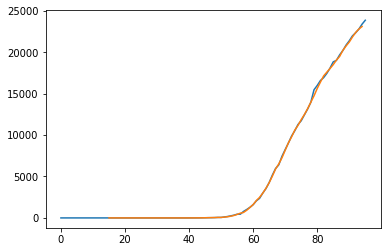

In [97]:
# generate predictions for training
trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_portugal_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
# testPredictPlot = np.empty_like(dp_portugal_cases)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_portugal_cases)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_portugal_cases)
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [102]:
prevision =  []
for i in range(days_predict_future):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_portugal_cases[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [103]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

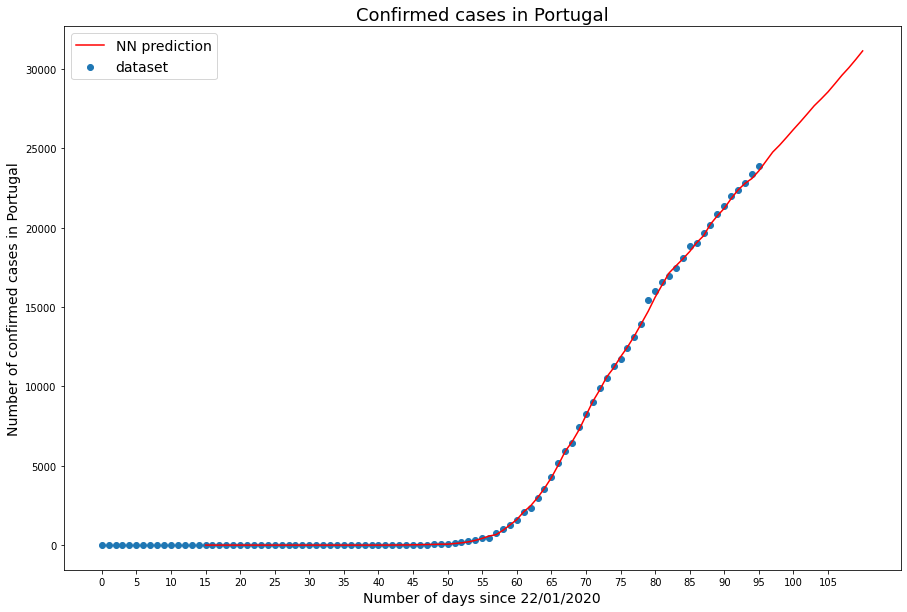

In [121]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_portugal_cases, label='dataset')
plt.title('Confirmed cases in Portugal', fontsize=18)
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days+days_predict_future), 5.0))
plt.xlabel('Number of days since 22/01/2020',fontsize=14)
plt.ylabel('Number of confirmed cases in Portugal',fontsize=14)
plt.plot(allTest, label='NN prediction', color='red')
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/NN_confirmed_portugal.png')
plt.show()

And here we can see the graph with all previsions made.

---

# Decision Tree

Although we cannot extrapolate values with the Decision Tree algorithm we still decided to implement it.  
This algorithm builds a tree where each node a decision is made, until a final decision is made at the leaf node. With this in mind, when we asked to predict how the next day, the next 15 days of the pandemic would be with this model, it was obvious it wouldn't work. The tree simply didn't have the necessary knowledge to predict that, it had no previous experience of how a day 100 would be in a covid19 pandemic.  

With all of this, this implementation still proved valuable since it made us figure out and understand the results we were seeing.

In [213]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

import numpy as np

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

number_days_predict = 15

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

train_days = np.array(epidemic_days[0:-number_days_predict]).reshape(-1, 1)
test_days = np.array(epidemic_days[-number_days_predict:]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

train_cases =  np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_cases = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

train_deaths = np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_deaths = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

train_recovered = np.array(world_recovered[0:-number_days_predict]).reshape(-1, 1)
test_recovered = np.array(world_recovered[-number_days_predict:]).reshape(-1, 1)

## Confirmed Cases DT

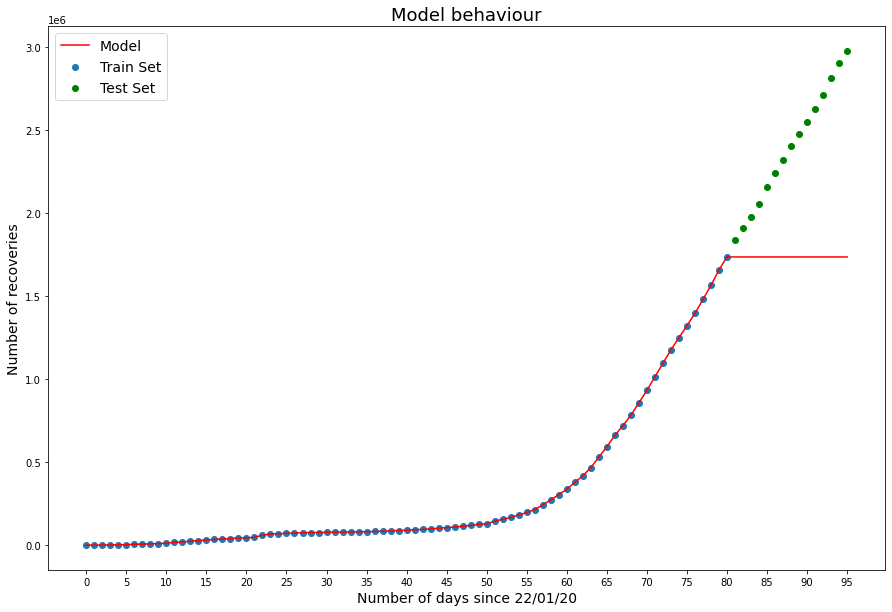

In [214]:
from sklearn.tree import DecisionTreeRegressor
        
dt = DecisionTreeRegressor()

dt.fit(train_days, train_cases.ravel())
pred = dt.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_cases, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_cases.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/dt_confirmed.png')
plt.show()

As expected, with values unkonw do the tree, the prediction falls on the last leaf node of the tree corresponding to the last value of the training set.

## Confirmed deaths DT

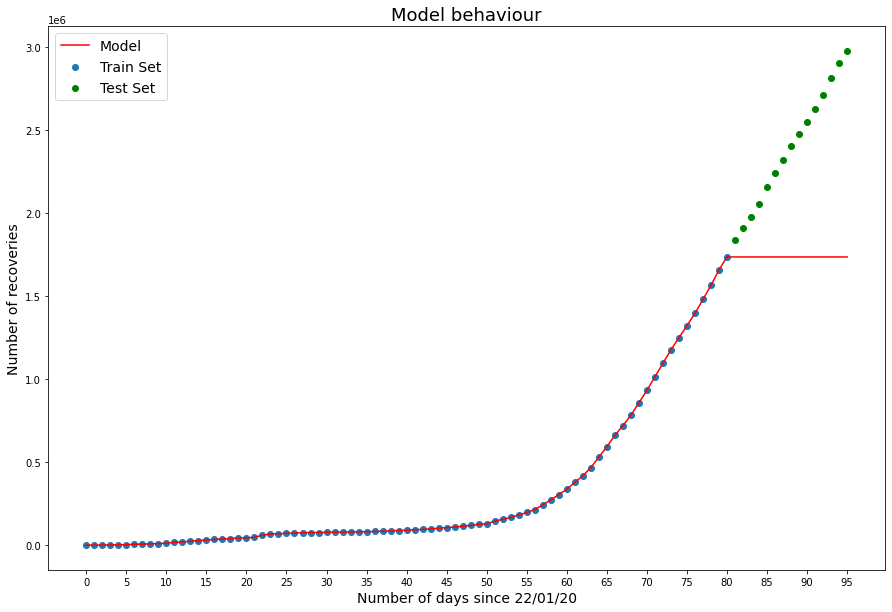

In [215]:
dt = DecisionTreeRegressor()

dt.fit(train_days, train_deaths.ravel())
pred = dt.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_deaths, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_deaths.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/dt_deaths.png')
plt.show()

## Confirmed recoveries DT

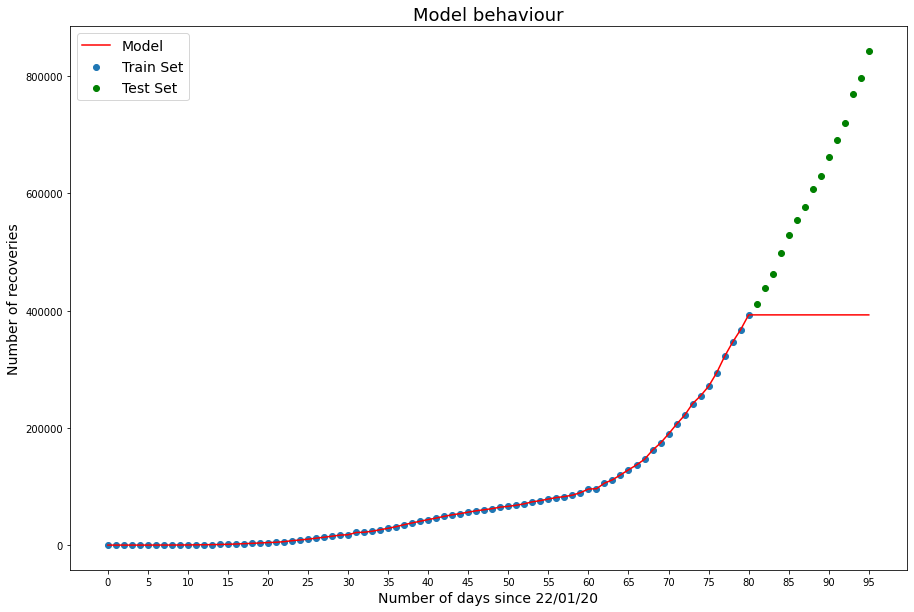

In [216]:
dt = DecisionTreeRegressor()

dt.fit(train_days, train_recovered.ravel())
pred = dt.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_recovered, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_recovered.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/dt_recovered.png')
plt.show()

# Conclusion

This project allowed us to have a deeper understanding of certain algorithms, like SVM, Neural Networks and Decision Trees. Dealing with various algorithms was an eye opening experience as it showed us that some algorithms are not intended to be used in some scenarios, while others are, and perform much better.  
In conclusion, this project helped us translate the knowledge gained in the theoretical classes into practice.  
Working with a very recent subject was also a good change of pace compared past projects mainly based on games.

# References

- https://machinelearningmastery.com/  
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)#/media/File:K-fold_cross_validation_EN.svg
- https://itnext.io/learning-data-science-predict-stock-price-with-support-vector-regression-svr-2c4fdc36662
- https://datascience.stackexchange.com/questions/51831/am-i-using-gridsearch-correctly-or-do-i-need-to-use-all-data-for-cross-validatio
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision%20tree#sklearn.tree.DecisionTreeRegressor